In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from datetime import datetime

In [2]:
df = pd.read_csv('cleaned_df.csv')

In [3]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.0,29
1,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.0,27
2,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.0,50
3,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.5,35
4,T7,C7126560,1992-01-26,F,MUMBAI,973.46,2016-02-08,17:38:06,566.0,31


In [4]:
# Convert CustomerDOB to datetime
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])

# Calculate Recency (R)
target_date = datetime(2017, 1, 1)
df['Recency'] = (target_date - pd.to_datetime(df['TransactionDate'])).dt.days

# Calculate Frequency (F)
frequency = df.groupby('CustomerID')['TransactionID'].count().reset_index()
frequency.columns = ['CustomerID', 'Frequency']
df = pd.merge(df, frequency, on='CustomerID')

# Calculate Monetary Value (M)
monetary_value = df.groupby('CustomerID')['TransactionAmount (INR)'].sum().reset_index()
monetary_value.columns = ['CustomerID', 'MonetaryValue']
df = pd.merge(df, monetary_value, on='CustomerID')

# Normalize RFM values using Min-Max scaling
df['Recency_Normalized'] = (df['Recency'] - df['Recency'].min()) / (df['Recency'].max() - df['Recency'].min())
df['Frequency_Normalized'] = (df['Frequency'] - df['Frequency'].min()) / (df['Frequency'].max() - df['Frequency'].min())
df['MonetaryValue_Normalized'] = (df['MonetaryValue'] - df['MonetaryValue'].min()) / (df['MonetaryValue'].max() - df['MonetaryValue'].min())

# Print the resulting DataFrame with both non-normalized and normalized RFM columns
print(df[['CustomerID', 'Recency', 'Frequency', 'MonetaryValue', 'Recency_Normalized', 'Frequency_Normalized', 'MonetaryValue_Normalized']])

       CustomerID  Recency  Frequency  MonetaryValue  Recency_Normalized  \
0        C5841053      328          1           25.0            0.907738   
1        C4417068      328          1          459.0            0.907738   
2        C5342380      328          2         2938.4            0.907738   
3        C5342380      141          2         2938.4            0.351190   
4        C9031234      328          1         1762.5            0.907738   
...           ...      ...        ...            ...                 ...   
901378   C1034220      105          1         1500.0            0.244048   
901379   C8020229      105          1          799.0            0.244048   
901380   C6459278      105          1          460.0            0.244048   
901381   C6412354      105          1          770.0            0.244048   
901382   C6420483      105          1         1000.0            0.244048   

        Frequency_Normalized  MonetaryValue_Normalized  
0                        0.0  

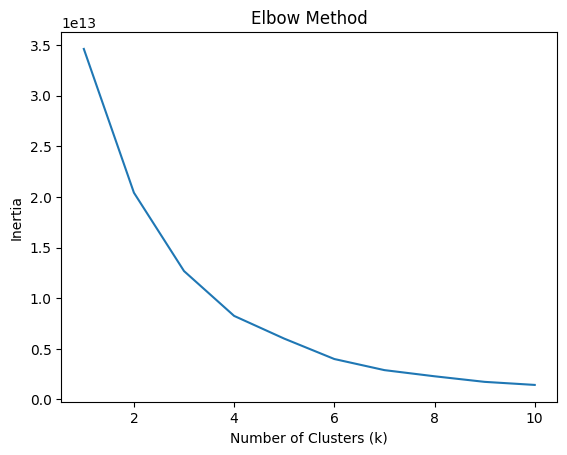

In [5]:
# Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df[['Recency', 'Frequency', 'MonetaryValue']])
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()




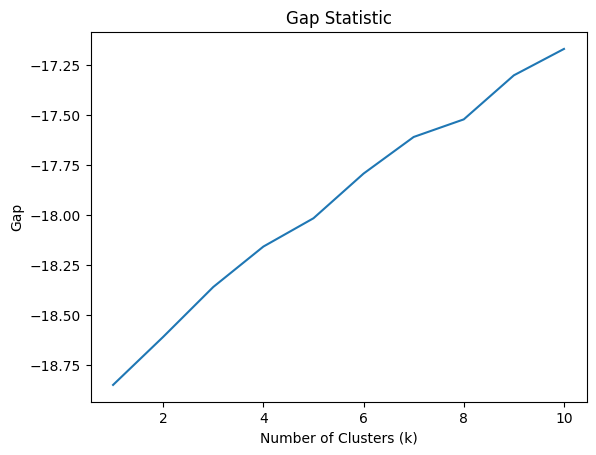

In [6]:
# Gap statistic
def compute_gap(data, k_max):
    gaps = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        within_dispersion = np.log(kmeans.inertia_)
        
        # Generate reference data
        reference_data = np.random.random_sample(size=data.shape)
        reference_kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        reference_kmeans.fit(reference_data)
        reference_dispersion = np.log(reference_kmeans.inertia_)
        
        gap = reference_dispersion - within_dispersion
        gaps.append(gap)
        
    return gaps

k_max = 10  # Maximum number of clusters to consider
gaps = compute_gap(df[['Recency', 'Frequency', 'MonetaryValue']], k_max)

plt.plot(range(1, k_max+1), gaps)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Gap')
plt.title('Gap Statistic')
plt.show()

In [7]:
# Apply K-means clustering
k = 4  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(df[['Recency', 'Frequency', 'MonetaryValue']])

# Get cluster labels for each customer
cluster_labels = kmeans.labels_

# Add the cluster labels to the original dataframe
df['Cluster'] = cluster_labels

# Print the resulting dataframe with cluster assignments
print(df[['CustomerID', 'Recency', 'Frequency', 'MonetaryValue', 'Cluster']])


       CustomerID  Recency  Frequency  MonetaryValue  Cluster
0        C5841053      328          1           25.0        0
1        C4417068      328          1          459.0        0
2        C5342380      328          2         2938.4        0
3        C5342380      141          2         2938.4        0
4        C9031234      328          1         1762.5        0
...           ...      ...        ...            ...      ...
901378   C1034220      105          1         1500.0        0
901379   C8020229      105          1          799.0        0
901380   C6459278      105          1          460.0        0
901381   C6412354      105          1          770.0        0
901382   C6420483      105          1         1000.0        0

[901383 rows x 5 columns]


In [8]:
# Calculate cluster statistics
cluster_stats = df.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'MonetaryValue': ['mean', 'median']
})
print(cluster_stats)

            Recency        Frequency         MonetaryValue          
               mean median      mean median           mean    median
Cluster                                                             
0        159.548365  134.0  1.301880    1.0    1179.876411     528.0
1        161.123064  134.0  1.559087    1.0   92462.310456   85699.0
2        161.174012  135.0  1.613358    1.0   23149.164281   20000.0
3        162.814815  132.0  1.814815    1.0  576354.785185  514320.0


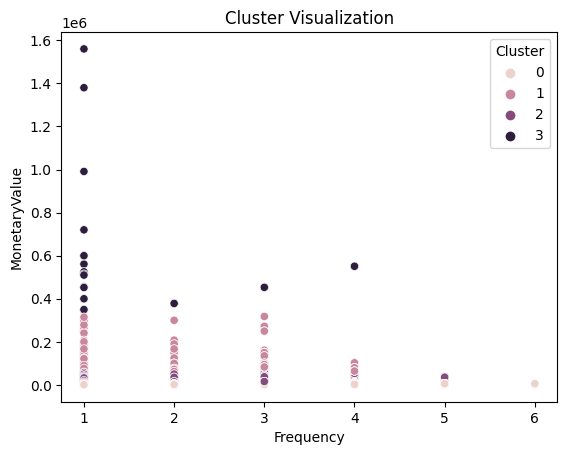

Cluster 0: 884722 customers
Cluster 2: 15407 customers
Cluster 1: 1227 customers
Cluster 3: 27 customers


In [9]:
sns.scatterplot(data=df, x='Frequency', y='MonetaryValue', hue='Cluster')
plt.xlabel('Frequency')
plt.ylabel('MonetaryValue')
plt.title('Cluster Visualization')
plt.show()

# Analyze segment characteristics
cluster_counts = df['Cluster'].value_counts()
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} customers")
    # Additional analysis and insights specific to each cluster can be performed here



In [10]:
# Calculate the average monetary value for each cluster
cluster_avg_monetary = df.groupby('Cluster')['MonetaryValue'].mean()

# Sort clusters based on average monetary value in descending order to identify high-value segments
high_value_segments = cluster_avg_monetary.sort_values(ascending=False)

# Calculate the contribution of each segment to overall revenue and profitability
total_revenue = df['MonetaryValue'].sum()
segment_revenue_contribution = cluster_avg_monetary * df.groupby('Cluster').size() / total_revenue

# Print the high-value segments and their revenue contribution
print("High-Value Segments:")
print(high_value_segments)
print()
print("Revenue Contribution of Each Segment:")
print(segment_revenue_contribution)

# Additional analysis and strategies can be developed based on the results

High-Value Segments:
Cluster
3    576354.785185
1     92462.310456
2     23149.164281
0      1179.876411
Name: MonetaryValue, dtype: float64

Revenue Contribution of Each Segment:
Cluster
0    0.682471
1    0.074174
2    0.233181
3    0.010174
dtype: float64


In [11]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age,Recency,Frequency,MonetaryValue,Recency_Normalized,Frequency_Normalized,MonetaryValue_Normalized,Cluster
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.0,29,328,1,25.0,0.907738,0.0,0.000016,0
1,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.0,27,328,1,459.0,0.907738,0.0,0.000294,0
2,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.0,50,328,2,2938.4,0.907738,0.2,0.001884,0
3,T391139,C5342380,1979-05-29,M,MUMBAI,3195.78,2016-08-13,19:41:48,878.4,44,141,2,2938.4,0.351190,0.2,0.001884,0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.5,35,328,1,1762.5,0.907738,0.0,0.001130,0


In [12]:
df.to_csv('cluster.csv', index=False)

# CLTV Prediction

In [13]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

In [14]:
df['Recency'] = (df['TransactionDate'].max() - df['TransactionDate']).dt.days

In [15]:
monetary_value = df.groupby('CustomerID')['TransactionAmount (INR)'].sum().reset_index()
monetary_value.columns = ['CustomerID', 'MonetaryValue']

In [16]:
average_purchase_value = df.groupby('CustomerID')['TransactionAmount (INR)'].mean().reset_index()
average_purchase_value.columns = ['CustomerID', 'AveragePurchaseValue']


In [17]:
purchase_frequency = df.groupby('CustomerID')['TransactionID'].count().reset_index()
purchase_frequency.columns = ['CustomerID', 'PurchaseFrequency']


In [18]:
df = pd.merge(df, monetary_value, on='CustomerID')

In [19]:

df = pd.merge(df, average_purchase_value, on='CustomerID')
df = pd.merge(df, purchase_frequency, on='CustomerID')

In [20]:
df['CLTV'] = (df['AveragePurchaseValue'] * df['PurchaseFrequency']) * df['Recency']

In [21]:
# One-hot encoding example
df = pd.get_dummies(df, columns=['CustGender'], prefix=['Gender'])

In [22]:
df.drop_duplicates(subset='CustomerID', keep='first', inplace=True)

In [23]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age,Recency,...,Recency_Normalized,Frequency_Normalized,MonetaryValue_Normalized,Cluster,MonetaryValue_y,AveragePurchaseValue,PurchaseFrequency,CLTV,Gender_F,Gender_M
0,T1,C5841053,1994-10-01,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.0,29,305,...,0.907738,0.0,0.000016,0,25.0,25.00,1,7625.0,1,0
1,T3,C4417068,1996-11-26,MUMBAI,17874.44,2016-02-08,14:27:12,459.0,27,305,...,0.907738,0.0,0.000294,0,459.0,459.00,1,139995.0,1,0
2,T4,C5342380,1973-09-14,MUMBAI,866503.21,2016-02-08,14:27:14,2060.0,50,305,...,0.907738,0.2,0.001884,0,2938.4,1469.20,2,896212.0,1,0
4,T5,C9031234,1988-03-24,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.5,35,305,...,0.907738,0.0,0.001130,0,1762.5,1762.50,1,537562.5,1,0
5,T7,C7126560,1992-01-26,MUMBAI,973.46,2016-02-08,17:38:06,566.0,31,305,...,0.907738,0.6,0.000526,0,821.0,205.25,4,250405.0,1,0


In [25]:
cluster_stats = df.groupby('Cluster')['CLTV'].describe()
pd.options.display.float_format = '{:.0f}'.format

# Print the cluster statistics dataframe
print(cluster_stats)

         count     mean      std    min      25%      50%       75%       max
Cluster                                                                      
0       765131   148091   280242      0    15582    52832    154008   4061878
1          937 13067288  9546273      0  7038000 10600000  17306188  80710545
2        11457  3263776  2502213      0  1596492  2600000   4251975  18614077
3           20 79487052 56650547 520010 36697479 57175740 117346787 198720320


In [29]:
# Select relevant features and target variable
features = ['Recency', 'Frequency', 'MonetaryValue_y', 'Gender_F','Gender_M','CustAccountBalance','Age','TransactionAmount (INR)','Cluster']
target = 'CLTV'

# Prepare the data
X = df[features]
y = df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Print the shapes of the split datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (622036, 9) (622036,)
Testing set shape: (155509, 9) (155509,)


In [30]:
# Linear Regression
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
linear_regression_predictions = linear_regression.predict(X_test)

# Decision Trees
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
decision_tree_predictions = decision_tree.predict(X_test)

# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
random_forest_predictions = random_forest.predict(X_test)

# Evaluation
def evaluate_model(predictions, actual):
    mse = mean_squared_error(actual, predictions)
    mae = mean_absolute_error(actual, predictions)
    r2 = r2_score(actual, predictions)
    return mse, mae, r2

linear_regression_eval = evaluate_model(linear_regression_predictions, y_test)
decision_tree_eval = evaluate_model(decision_tree_predictions, y_test)
random_forest_eval = evaluate_model(random_forest_predictions, y_test)

print("Linear Regression Evaluation:")
print("Mean Squared Error:", linear_regression_eval[0])
print("Mean Absolute Error:", linear_regression_eval[1])
print("R-squared Score:", linear_regression_eval[2])
print()

print("Decision Tree Evaluation:")
print("Mean Squared Error:", decision_tree_eval[0])
print("Mean Absolute Error:", decision_tree_eval[1])
print("R-squared Score:", decision_tree_eval[2])
print()

print("Random Forest Evaluation:")
print("Mean Squared Error:", random_forest_eval[0])
print("Mean Absolute Error:", random_forest_eval[1])
print("R-squared Score:", random_forest_eval[2])

Linear Regression Evaluation:
Mean Squared Error: 174454667017.03915
Mean Absolute Error: 108778.89852063918
R-squared Score: 0.7677953100512451

Decision Tree Evaluation:
Mean Squared Error: 26053962838.567875
Mean Absolute Error: 1946.205538907716
R-squared Score: 0.965321349859473

Random Forest Evaluation:
Mean Squared Error: 13869947689.292755
Mean Absolute Error: 1189.5705478248856
R-squared Score: 0.9815386601122966
